<a href="https://colab.research.google.com/github/Anteii/HPC-Labs/blob/main/lab1/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from IPython.display import clear_output

In [2]:
!nvidia-smi

Sun Oct  9 18:54:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/NVIDIA/cuda-samples.git
!make -C /content/cuda-samples/Samples/1_Utilities/deviceQuery
clear_output()
!/content/cuda-samples/bin/x86_64/linux/release/deviceQuery

/content/cuda-samples/bin/x86_64/linux/release/deviceQuery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          11.2 / 11.2
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15110 MBytes (15843721216 bytes)
  (040) Multiprocessors, (064) CUDA Cores/MP:    2560 CUDA Cores
  GPU Max Clock rate:                            1590 MHz (1.59 GHz)
  Memory Clock rate:                             5001 Mhz
  Memory Bus Width:                              256-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory:    

In [4]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
clear_output()

In [5]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# Test program

In [6]:
%%cu
#include <iostream>

int main()
{
    std::cout << "Hello CUDA World!" << std::endl;
    return 0;
}

Hello CUDA World!



# Matrix Multiplication

In [38]:
%%cu
#include <cstdio>
#include <iostream>
#include <ctime>
#include "assert.h"
using namespace std;


__global__ void matMulKernel(int* mat1, int* mat2, int* res, int N, int M, int K){
     int row = blockIdx.y * blockDim.y + threadIdx.y;
     int col = blockIdx.x * blockDim.x + threadIdx.x;

     if (row < N && col < K){
         res[row * K + col] = 0;
         for (int i = 0; i < M; ++i) {
            res[row * K + col] += mat1[row * M + i] * mat2[i * K + col];
        }
     }
}

float cpuMatMul(int* mat1, int* mat2, int* res, int N, int M, int K){
    
    clock_t start, end;

    start = clock();

    for (int i = 0; i < N; ++i){
        for (int j = 0; j < K; ++j){
            int t = 0;
            for (int k = 0; k < M; ++k){
                t += mat1[i * M + k] * mat2[k * K + j];
            }
            res[i * K + j] = t;
        } 
    }

    end = clock();
    
    return 1.0f * (end - start) / CLOCKS_PER_SEC;
}

void printMatrix(int* mat, int N, int M){
    for (int i = 0; i < N; ++i){
        for (int j = 0; j < M; ++j){
            cout << mat[i * M + j] << " ";
        }
        cout << endl;
    }
}

void randomFillCPU(int* mat, int N, int M, float scale = 1, float bias = 0, int mod = RAND_MAX){
  for (int i = 0; i < N * M; ++i){
      mat[i] = int(scale * (rand() % mod) + bias);
  }
}

void checkError(cudaError_t error){
	if (error != cudaSuccess){
		cout << "Error" << endl;
		cerr << cudaGetErrorString(error) << endl;
		exit(1);
	}
}

float gpuMatMul(int* mat1, int* mat2, int* res, int N, int M, int K){

    // Declare needed variables
    int mat1_size = N * M * sizeof(int);
    int mat2_size = M * K * sizeof(int);
    int res_size = N * K * sizeof(int);

    int* mat1_dev;
    int* mat2_dev;
    int* res_dev;

    float start, end, totalTime;
	  cudaEvent_t startEvent, stopEvent;

		// Allocate memory on device
		checkError(cudaMalloc(&mat1_dev, mat1_size));
		checkError(cudaMalloc(&mat2_dev, mat2_size));
		checkError(cudaMalloc(&res_dev, res_size));

    // Copy mat1 and mat2 from host to device
    checkError(cudaMemcpy(mat1_dev, mat1, mat1_size, cudaMemcpyHostToDevice)); 
    checkError(cudaMemcpy(mat2_dev, mat2, mat2_size, cudaMemcpyHostToDevice));

    // Create events for fixing time
    checkError(cudaEventCreate(&startEvent));
	  checkError(cudaEventCreate(&stopEvent));

    // Create threads and blocks topography
    dim3 blockDim(32, 32, 1); // Up to 1024 threads
    
    int gridX = (K - 1) / blockDim.x + 1;
    int gridY = (N - 1) / blockDim.y + 1;
     
    dim3 gridDim(gridX, gridY, 1);

    // Write down current time
    checkError(cudaEventRecord(startEvent, 0));

    // Multiplicate matricies
    matMulKernel<<<gridDim, blockDim>>>(mat1_dev, mat2_dev, res_dev, N, M, K);

    // Write down current time
    checkError(cudaEventRecord(stopEvent, 0));
	
    // Synchronize device
    checkError(cudaDeviceSynchronize());

    // Calculate and print elapsed time
    checkError(cudaEventElapsedTime(&totalTime, startEvent, stopEvent));

    // Copy result from device to host
    checkError(cudaMemcpy(res, res_dev, res_size, cudaMemcpyDeviceToHost));

    // Free device memory
    cudaFree(mat1_dev);
    cudaFree(mat2_dev);
    cudaFree(res_dev);

    // in seconds
    return totalTime / 1000;
}

bool checkEquality(int* mat1, int* mat2, int N){
	bool flag = true;
	
	for (int i = 0; i < N; ++i){
      if (mat1[i] != mat2[i]){
          flag = false;
          break;
      }
  }

  return flag;
}

void experiment(int N, int M, int K, int repeats, 
                float* cpuTime, float* gpuTime){
    
    *cpuTime = 0;
    *gpuTime = 0;

    int* mat1 = (int*)malloc(N * M * sizeof(int));
    int* mat2 = (int*)malloc(M * K * sizeof(int));
    int* gpu_res = (int*)malloc(N * K * sizeof(int));
    int* cpu_res = (int*)malloc(N * K * sizeof(int));

    for (int repeat = 0; repeat < repeats; ++repeat){
        randomFillCPU(mat1, N, M, 1, 0, 64);
        randomFillCPU(mat2, M, K, 1, 0, 64);

        *cpuTime += cpuMatMul(mat1, mat2, cpu_res, N, M, K);
        *gpuTime += gpuMatMul(mat1, mat2, gpu_res, N, M, K);
        
        assert(checkEquality(cpu_res, gpu_res, N * K));
    }
    
    *cpuTime /= repeats;
    *gpuTime /= repeats;

    cout << "CPU Time: " << *cpuTime << endl;
    cout << "GPU Time: " << *gpuTime << endl;
    
    free(mat1);
    free(mat2);
    free(gpu_res);
    free(cpu_res);
}


int main(){
  srand(42);

  // N is a height of the first matrix
  // M is a width of the first matrix and height of the second matrix
  // K is a height of the second matrix

  int N, M, K;

  int expNum = 50;
  int nRuns = 4;

  int* paramN = (int*)malloc(expNum * sizeof(int));
  int* paramM = (int*)malloc(expNum * sizeof(int));
  int* paramK = (int*)malloc(expNum * sizeof(int));
  float* paramCpuTime = (float*)malloc(expNum * sizeof(float));
  float* paramGpuTime = (float*)malloc(expNum * sizeof(float));


  for (int i = 0; i < expNum; ++i){
      
      paramN[i] = (100 + rand()) % 1200;
      paramM[i] = (100 + rand()) % 1200;
      paramK[i] = (100 + rand()) % 1200;

      //paramN[i] = paramM[i] = paramK[i] = (100 + rand()) % 2000;
      //paramN[i] = paramM[i] = paramK[i] = 10 * (1 << i);

      cout << "N = " << paramN[i] << " M = " << paramM[i] << " K = " << paramK[i] << endl;
      experiment(paramN[i], paramM[i], paramK[i], nRuns, 
                 paramCpuTime + i, paramGpuTime + i);
  }

  // For easy conversion to python
  cout << endl;
  cout << "N: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramN[i] << " ";
  }
  cout << endl;

  cout << "M: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramM[i] << " ";
  }
  cout << endl;

  cout << "K: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramK[i] << " ";
  }
  cout << endl;

  cout << "cpuTime: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramCpuTime[i] << " ";
  }
  cout << endl;

  cout << "gpuTime: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramGpuTime[i] << " ";
  }

  cout << endl;

  free(paramN);
  free(paramM);
  free(paramK);
  free(paramCpuTime);
  free(paramGpuTime);

  return 0;
}

N = 1066 M = 40 K = 981
CPU Time: 0.123595
GPU Time: 0.000807936
N = 680 M = 1175 K = 3
CPU Time: 0.0063035
GPU Time: 0.00044236
N = 57 M = 1183 K = 584
CPU Time: 0.145082
GPU Time: 0.000526424
N = 452 M = 431 K = 264
CPU Time: 0.156318
GPU Time: 0.000763728
N = 1060 M = 10 K = 535
CPU Time: 0.0157213
GPU Time: 0.00013128
N = 12 M = 1058 K = 302
CPU Time: 0.0154645
GPU Time: 0.000431104
N = 227 M = 1087 K = 640
CPU Time: 0.578076
GPU Time: 0.0020171
N = 687 M = 1028 K = 754
CPU Time: 2.28757
GPU Time: 0.00949288
N = 515 M = 372 K = 588
CPU Time: 0.360481
GPU Time: 0.00187131
N = 789 M = 843 K = 536
CPU Time: 1.31123
GPU Time: 0.00425307
N = 257 M = 623 K = 705
CPU Time: 0.473508
GPU Time: 0.00228514
N = 167 M = 878 K = 771
CPU Time: 0.481201
GPU Time: 0.00229698
N = 557 M = 389 K = 292
CPU Time: 0.198811
GPU Time: 0.00112204
N = 292 M = 793 K = 146
CPU Time: 0.11092
GPU Time: 0.000933888
N = 97 M = 214 K = 349
CPU Time: 0.0215655
GPU Time: 0.000169144
N = 1082 M = 1181 K = 770
CPU Time

# Visualization

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Square matrices

In [9]:
params = {
    "N": "10 20 40 80 160 320 640 1280",
    "M": "10 20 40 80 160 320 640 1280",
    "K": "10 20 40 80 160 320 640 1280",
    "cpuTime": "4.25e-06 2.525e-05 0.0001835 0.0013995 0.011212 0.114941 0.948382 13.4131",
    "gpuTime": "1.4568e-05 1.6696e-05 2.4728e-05 3.908e-05 9.0032e-05 0.000464648 0.00307926 0.0299518",
}

for key in ["M", "N", "K"]:
  params[key] = np.array(list(map(int, params[key].split())))
for key in ["cpuTime", "gpuTime"]:
  params[key] = np.array(list(map(float, params[key].split())))

expNum = len(params["N"])

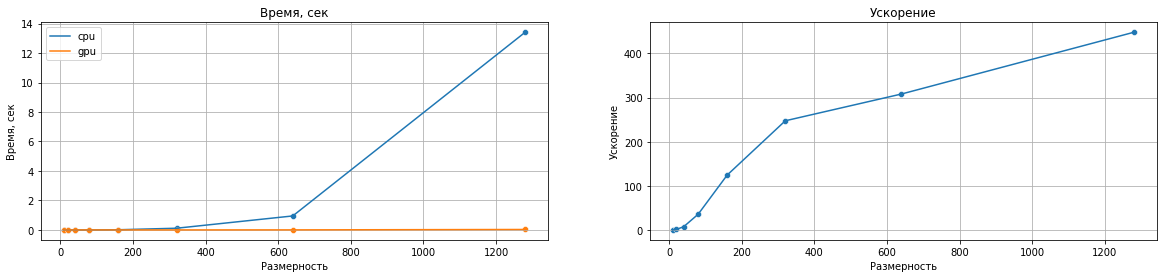

In [35]:
N, gpu_time = zip(*sorted(zip(params["N"], params["gpuTime"])))
N, cpu_time = zip(*sorted(zip(params["N"], params["cpuTime"])))

N, cpu_time, gpu_time = np.array(N), np.array(cpu_time), np.array(gpu_time)

speed_up = cpu_time / gpu_time

fig, axs = plt.subplots(ncols=2, figsize=(20, 4))

axs[0].set_title("Время, сек")
axs[0].set_xlabel("Размерность")
axs[0].set_ylabel("Время, сек")
axs[0].grid()
sns.scatterplot(x=N, y=cpu_time, ax=axs[0])
sns.scatterplot(x=N, y=gpu_time, ax=axs[0])
sns.lineplot(x=N, y=cpu_time, ax=axs[0], label="cpu")
sns.lineplot(x=N, y=gpu_time, ax=axs[0], label="gpu")

axs[1].set_title("Ускорение")
axs[1].set_xlabel("Размерность")
axs[1].set_ylabel("Ускорение")
axs[1].grid()

sns.scatterplot(x=N, y=speed_up, ax=axs[1])
sns.lineplot(x=N, y=speed_up, ax=axs[1]);

## Recatangular matrices

In [10]:
params = {
    "N": "1066 680 57 452 1060 12 227 687 515 789 257 167 557 292 97 1082 287 175 903 1129 214 639 903 246 846 401 1117 192 1013 536 502 847 121 1064 734 1195 328 18 341 414 624 522 309 258 634 1040 977 221 227 959",
    "M": "40 1175 1183 431 10 1058 1087 1028 372 843 623 878 389 793 214 1181 286 925 185 591 90 287 510 522 66 768 580 568 408 1124 406 946 47 291 794 248 670 737 522 485 934 491 775 1023 431 63 501 1024 1171 369",
    "K": "981 3 584 264 535 302 640 754 588 536 705 771 292 146 349 770 580 818 800 791 511 855 1050 336 1138 1126 234 426 342 415 667 326 200 488 81 493 302 783 980 142 663 825 928 755 755 1151 958 244 122 453",
    "cpuTime": "0.123595 0.0063035 0.145082 0.156318 0.0157213 0.0154645 0.578076 2.28757 0.360481 1.31123 0.473508 0.481201 0.198811 0.11092 0.0215655 4.23753 0.145718 0.560846 0.408547 2.24869 0.0292933 0.543362 2.04313 0.142347 0.193414 1.50414 0.491337 0.173 0.476262 1.05543 0.49902 1.04649 0.0034555 0.456641 0.144896 0.478369 0.224051 0.0432028 0.659895 0.0826302 1.63285 0.86858 0.810214 0.857236 0.813012 0.217706 1.97355 0.186941 0.112354 0.498325",
    "gpuTime": "0.000807936 0.00044236 0.000526424 0.000763728 0.00013128 0.000431104 0.0020171 0.00949288 0.00187131 0.00425307 0.00228514 0.00229698 0.00112204 0.000933888 0.000169144 0.0172015 0.0008422 0.00248865 0.00160691 0.00965902 0.000212424 0.00292965 0.00838288 0.000666912 0.00114163 0.00621708 0.00281568 0.00094592 0.00253711 0.00500331 0.00259422 0.00476916 3.1656e-05 0.00186874 0.00111341 0.00277078 0.00140486 0.000327016 0.00275576 0.00068016 0.00721754 0.00396942 0.00277522 0.00397262 0.00374874 0.00140115 0.00807303 0.0012218 0.000818984 0.00302144 ",
}

for key in ["M", "N", "K"]:
  params[key] = np.array(list(map(int, params[key].split())))
for key in ["cpuTime", "gpuTime"]:
  params[key] = np.array(list(map(float, params[key].split())))

expNum = len(params["N"])

Credits for display code: https://stackoverflow.com/questions/14995610/how-to-make-a-4d-plot-with-matplotlib-using-arbitrary-data

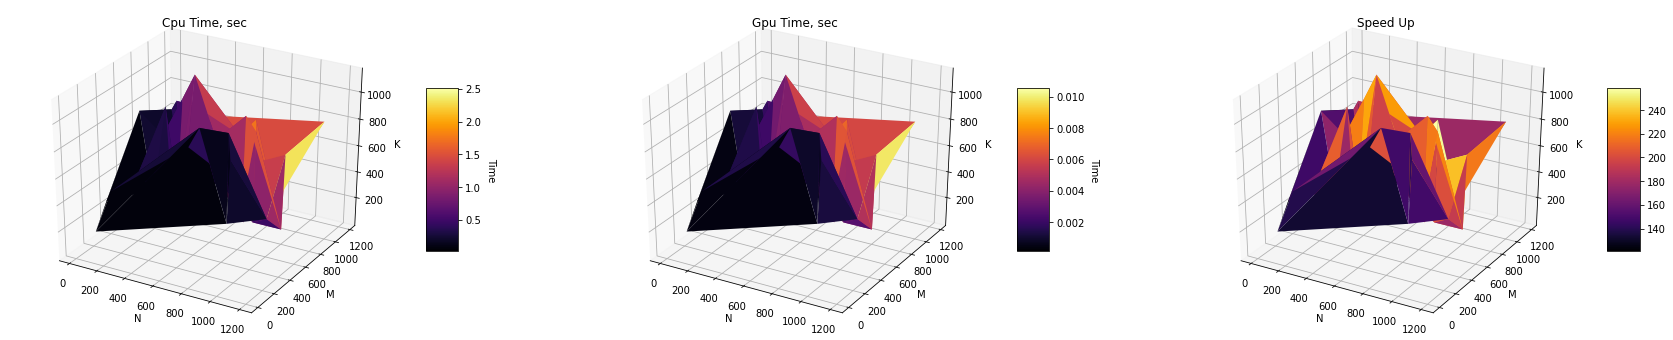

In [11]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

def plot4d(n, m, k, times, ax, c_label="Time", cmap = "seismic"):

  triangles = mtri.Triangulation(n, m).triangles;

  colors = np.mean([
      times[triangles[:,0]], 
      times[triangles[:,1]], 
      times[triangles[:,2]]
  ], axis = 0);

  triang = mtri.Triangulation(n, m, triangles);
  surf = ax.plot_trisurf(triang, k, cmap = cmap, shade=False, linewidth=0.2);
  surf.set_array(colors); 
  surf.autoscale();

  cbar = fig.colorbar(surf, shrink=0.5, aspect=5);
  cbar.ax.get_yaxis().labelpad = 15; 
  
  cbar.ax.set_ylabel(c_label, rotation = 270);
  ax.set_xlabel("N"); 
  ax.set_ylabel("M");
  ax.set_zlabel("K");

  #ax.invert_xaxis()

n, m, k = params["N"], params["M"], params["K"]
cpu_time, gpu_time = params["cpuTime"], params["gpuTime"]

cpu_time, gpu_time = np.array(cpu_time), np.array(gpu_time)
speed_up = cpu_time / gpu_time

fig = plt.figure(figsize=(30, 6));

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title("Cpu Time, sec")
plot4d(n, m, k, cpu_time, ax, c_label="Time", cmap="inferno")

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_title("Gpu Time, sec")
plot4d(n, m, k, gpu_time, ax, c_label="Time", cmap="inferno")

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_title("Speed Up")
plot4d(n, m, k, speed_up, ax, c_label="", cmap="inferno")

#fig.text(0.2, 0.1, "textsrt")
#fig.subplots_adjust(bottom=0.25)
plt.show();